In [1]:
import os 
import sys

import numpy as np
import pandas as pd

In [2]:
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn
from mxnet import autograd

In [3]:
# Data Path
root = 'data_pre_processing512/'
TRAIN_PATH = 'stage1_train/'
VAL_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

# Get train and test IDs
train_val_ids = next(os.walk(root+TRAIN_PATH))[1]
test_ids = next(os.walk(root+TEST_PATH))[1]
print (len(train_val_ids))

660


In [4]:
sample = int(len(train_val_ids)*0.9)
np.random.shuffle(train_val_ids)
train_ids = train_val_ids[:sample]
val_ids = train_val_ids[sample:]
print (len(train_ids),len(val_ids))

594 66


In [5]:
from mxnet import image

def read_images( dataset=TRAIN_PATH, ids=train_ids):
    n = len(ids)
    data, label ,weight = [None] * n, [None] * n, [None] * n
    for i, fname in enumerate(ids):
        path = root+dataset+fname
        data[i] = image.imread('%s/images/%s.png' % (path, fname))
        label[i] = image.imread('%s/gts/%s.png' % (path, fname),flag=0)
        weight[i] = image.imread('%s/edges/%s.png' % (path, fname),flag=0)
        #print (label[i].shape,label[i].dtype)
    return data, label, weight

66 (512, 512, 3)
670ebd9d674be236b9bf0b28650ad3f68e1891b06e16a9021fd069ca7ef32b78


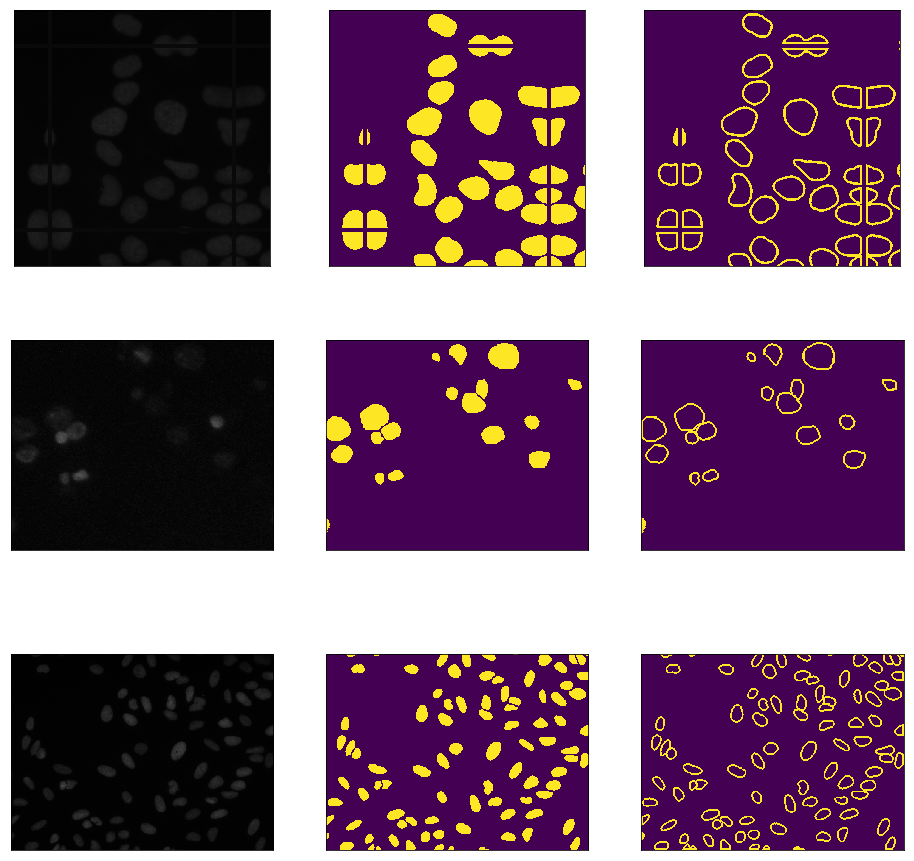

[(512, 512, 3),
 (512, 512),
 (512, 512),
 (512, 640, 3),
 (512, 640),
 (512, 640),
 (520, 696, 3),
 (520, 696),
 (520, 696)]

In [6]:
import utils

train_images, train_labels, train_weights = read_images(VAL_PATH,val_ids)
print (len(train_images),train_images[0].shape)
imgs = []

print (val_ids[0])
for i in range(3):
    imgs += [train_images[i], train_labels[i][:,:,0],train_weights[i][:,:,0]]


utils.show_images(imgs, nrows=3, ncols=3, figsize=(16,16))
[im.shape for im in imgs]

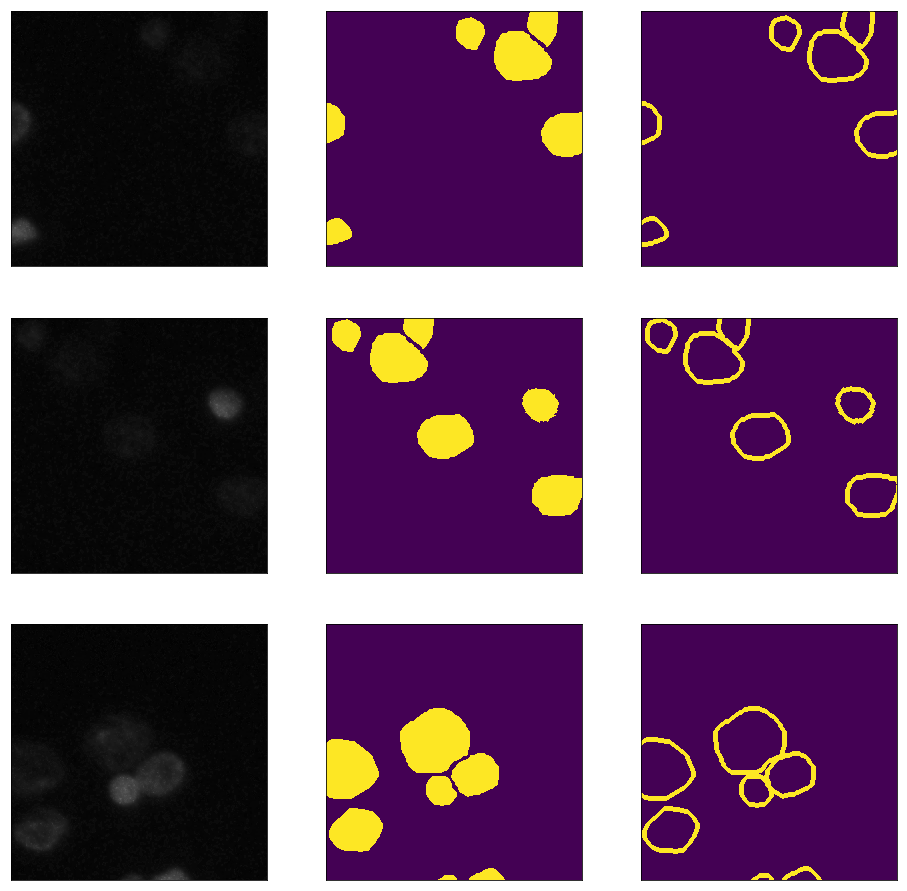

[(256, 256, 3),
 (256, 256),
 (256, 256),
 (256, 256, 3),
 (256, 256),
 (256, 256),
 (256, 256, 3),
 (256, 256),
 (256, 256)]

In [7]:
def rand_crop(data, label, weight, height, width):
    data, rect = image.random_crop(data, (width, height))
    label = image.fixed_crop(label, *rect)
    weight = image.fixed_crop(weight, *rect)
    return data, label, weight

imgs = []
for _ in range(3):
    data_,label_, weight_= rand_crop(train_images[1], train_labels[1], train_weights[1], 256, 256)
    imgs += [data_, label_[:,:,0], weight_[:,:,0]]
    
utils.show_images(imgs, nrows=3, ncols=3, figsize=(16,16))
[im.shape for im in imgs]

In [8]:
rgb_mean = nd.array([0.19377533,  0.18068263,  0.19943969])
rgb_std = nd.array([0.08733674,  0.09551049,  0.07832322])

def normalize_image(data):
    return (data.astype('float32')/ 255 - rgb_mean) / rgb_std

lamdba1 = 2
class SegDataset(gluon.data.Dataset):
    def __init__(self, dataset, ids, crop_size):
        self.crop_size = crop_size
        data, label, weight = read_images(dataset, ids)
        self.data = [normalize_image(im) for im in data]
        self.label = [lb.astype('float32') / 255 for lb in label]
        self.weight = [w.astype('float32') / 255 for w in weight]
        
        print('Read '+str(len(self.data))+' examples')

    def __getitem__(self, idx):
        data, label, weight = rand_crop(self.data[idx], self.label[idx], self.weight[idx],*self.crop_size)
        auglist = [image.ColorJitterAug(brightness=0.1, contrast=0.1, saturation=0.1)] 
        for aug in auglist:
            data = aug(data)
            
        h_flip=np.random.randint(2)
        v_flip=np.random.randint(2)
        if h_flip:
            data = data.flip(axis=0)
            label= label.flip(axis=0)
            weight=weight.flip(axis=0)
        if v_flip:
            data = data.flip(axis=1)
            label= label.flip(axis=1)
            weight=weight.flip(axis=1)
            
        data = data.transpose((2,0,1))
        label = label.transpose((2,0,1))
        
        weight = weight.transpose((2,0,1))
        w0 = nd.ones_like(weight)
        weight = weight * lamdba1 +w0
        sum1 = nd.mean(weight)
        weight = weight/sum1
        
        return data, label, weight

    def __len__(self):
        return len(self.data)

In [9]:
input_shape = (256, 256)
voc_train = SegDataset(TRAIN_PATH, train_ids, input_shape)
voc_val = SegDataset(VAL_PATH, val_ids, input_shape)
#voc_train_val = SegDataset(TRAIN_PATH, train_val_ids, input_shape)

Read 594 examples
Read 66 examples


In [10]:
print (len(voc_train.data),voc_train.data[0].shape)

594 (1024, 1024, 3)


In [11]:
#print (voc_train.data[1][100:116,100:116,0],voc_train.data[1].dtype)
#print (voc_train.label[1][100:116,100:116,0],voc_train.label[1].shape,voc_train.data[1].shape)

In [12]:
batch_size = 16
train_data = gluon.data.DataLoader(voc_train, batch_size, shuffle=True,last_batch='keep')
val_data = gluon.data.DataLoader(voc_val, 2,last_batch='keep')
#train_val_data = gluon.data.DataLoader(voc_train_val, batch_size, shuffle=True,last_batch='keep')

print(len(train_data),len(val_data))

for data, label, weight in train_data:
    print(data.shape,label.shape,weight.shape)
    print(label[1,0,:,:],label.dtype)
    print(weight[1,0,:,:],weight.dtype)
    break

38 33
(16, 3, 256, 256) (16, 1, 256, 256) (16, 1, 256, 256)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
<NDArray 256x256 @cpu(0)> <class 'numpy.float32'>

[[ 0.75695902  0.75695902  2.27087712 ...,  0.75695902  0.75695902
   0.75695902]
 [ 0.75695902  0.75695902  2.27087712 ...,  0.75695902  0.75695902
   0.75695902]
 [ 0.75695902  0.75695902  2.27087712 ...,  0.75695902  0.75695902
   0.75695902]
 ..., 
 [ 0.75695902  0.75695902  0.75695902 ...,  0.75695902  0.75695902
   0.75695902]
 [ 0.75695902  0.75695902  0.75695902 ...,  0.75695902  0.75695902
   0.75695902]
 [ 0.75695902  0.75695902  0.75695902 ...,  0.75695902  0.75695902
   0.75695902]]
<NDArray 256x256 @cpu(0)> <class 'numpy.float32'>


In [13]:
def ConvBlock(channels, kernel_size):
    out = nn.HybridSequential()
    #with out.name_scope():
    out.add(
        nn.Conv2D(channels, kernel_size, padding=1, use_bias=False),
        nn.BatchNorm(),
        nn.LeakyReLU(0.1)
        #nn.Activation('relu')
    )
    return out

In [14]:
def down_block(channels):
    out = nn.HybridSequential()
    #with out.name_scope():
    out.add(
        ConvBlock(channels, 3),
        ConvBlock(channels, 3)
    )
    return out


In [15]:
class up_block(nn.HybridBlock):
    def __init__(self, channels, shrink=True, **kwargs):
        super(up_block, self).__init__(**kwargs)
        #with self.name_scope():
        self.upsampler = nn.Conv2DTranspose(channels=channels, kernel_size=4, strides=2, 
                         padding=1, use_bias=False, weight_initializer=mx.init.Bilinear())
        
        #self.upsampler.collect_params().setattr('lr_mult', 0.)
        #self.conv1_1 = nn.Conv2D(channels, 1 ,use_bias=False)
        self.conv3_0 = ConvBlock(channels, 3)
        if shrink:
            self.conv3_1 = ConvBlock(int(channels/2), 3)
        else:
            self.conv3_1 = ConvBlock(channels, 3)
    def hybrid_forward(self, F, x, s):
        x = self.upsampler(x)
        #x = self.conv1_1(x)
        #x = F.relu(x)
        
        x = F.Crop(*[x,s], center_crop=True)
        x = F.concat(s,x, dim=1)
        #x = s + x
        x = self.conv3_0(x)
        x = self.conv3_1(x)
        return x


In [16]:
class Segnet(nn.HybridBlock):
    def __init__(self, **kwargs):
        super(Segnet, self).__init__(**kwargs)
        with self.name_scope():
            self.d0 = down_block(16)
            
            self.d1 = nn.HybridSequential()
            self.d1.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(32))
            
            self.d2 = nn.HybridSequential()
            self.d2.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(64))
            
            self.d3 = nn.HybridSequential()
            self.d3.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(128))
            
            self.d4 = nn.HybridSequential()
            self.d4.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(256))
            
            self.u3 = up_block(128, shrink=True)
            self.u2 = up_block(64, shrink=True)
            self.u1 = up_block(32, shrink=True)
            self.u0 = up_block(16, shrink=False)
            
            self.conv = nn.Conv2D(1,1,activation='sigmoid',use_bias=False)
    def hybrid_forward(self, F, x):
        x0 = self.d0(x)
        x1 = self.d1(x0)
        x2 = self.d2(x1)
        x3 = self.d3(x2)
        x4 = self.d4(x3)

        y3 = self.u3(x4,x3)
        y2 = self.u2(y3,x2)
        y1 = self.u1(y2,x1)
        y0 = self.u0(y1,x0)
        
        out = self.conv(y0)
        
        return out

BCEloss = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
smooth_L1 = gluon.loss.HuberLoss(rho=0.3 )

In [17]:
# Metric function
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = nd.flatten(y_true)
    y_pred_f = nd.flatten(y_pred)>0.5
    intersection = nd.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (nd.sum(y_true_f) + nd.sum(y_pred_f) + smooth)
def IOU(y_true, y_pred):
    y_true_f = nd.flatten(y_true)
    y_pred_f = nd.flatten(y_pred)>0.5
    intersection = nd.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (nd.sum(y_true_f) + nd.sum(y_pred_f) - intersection + smooth)

smooth_weight = 1
tv_weight = 0.1
def tv_loss(yhat):
    return 0.5*((yhat[:,:,1:,:] - yhat[:,:,:-1,:]).abs().mean() +
                (yhat[:,:,:,1:] - yhat[:,:,:,:-1]).abs().mean())


In [18]:
import datetime

loss_train=[]
loss_valid=[]
acc_valid=[]

def get_batch(batch, ctx):
    """return data and label on ctx"""
    if isinstance(batch, mx.io.DataBatch):
        data = batch.data[0]
        label = batch.label[0]
        weight = batch.weight[0]
    else:
        data, label, weight = batch
    return (gluon.utils.split_and_load(data, ctx),
            gluon.utils.split_and_load(label, ctx),
            gluon.utils.split_and_load(weight, ctx),
            data.shape[0])

def get_loss(data, net, ctx):
    loss = 0.0
    acc = 0.0
    for i, batch in enumerate(data):
        feas, label, weight, batch_size = get_batch(batch, ctx)
        #label = label.as_in_context(ctx)
        output = net(feas[0])
        loss_BCE = BCEloss(output, label[0], weight[0]) + tv_weight * tv_loss(output>0.5)
        acc += nd.mean(IOU(label[0],output)).asscalar()
        loss += nd.mean(loss_BCE).asscalar()
    return (loss / len(data),acc / len(data))

def my_train(net, train_data, valid_data, num_epochs, lr, wd, ctx, lr_period, lr_decay):
    trainer = gluon.Trainer(
        net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.8, 
                                      'wd': wd})
    prev_time = datetime.datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0.0
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for i, batch in enumerate(train_data):
            data, label, weight, batch_size = get_batch(batch, ctx)
            #print (label[0].shape,len(label))
            #label = nd.array(label).as_in_context(ctx)
            with autograd.record():
                output = net(data[0])
                loss = BCEloss(output, label[0], weight[0])+ tv_weight * tv_loss(output>0.5)
            loss.backward()
            trainer.step(batch_size)
            train_loss += nd.mean(loss).asscalar()
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:  
            valid_loss , valid_acc = get_loss(valid_data, net, ctx)
            loss_valid.append(valid_loss)
            acc_valid.append(valid_acc)
            epoch_str = ("Epoch %d. Train loss: %f, Valid loss %f, Valid acc %f, "
                         % (epoch, train_loss / len(train_data), valid_loss, valid_acc))
        else:
            epoch_str = ("Epoch %d. Train loss: %f, "
                         % (epoch, train_loss / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str + ', lr ' + str(trainer.learning_rate))
        loss_train.append(train_loss / len(train_data))

In [19]:
ctx = [mx.gpu(0)]
num_epochs = 80
learning_rate = 0.005
weight_decay = 5e-3
lr_period = 20
lr_decay = 0.2

net = Segnet()
net.collect_params().initialize(init=mx.initializer.Xavier(),ctx=ctx)

net.hybridize()
my_train(net, train_data, val_data, num_epochs, learning_rate,
      weight_decay, ctx, lr_period, lr_decay)

Epoch 0. Train loss: 0.542975, Valid loss 0.535489, Valid acc 0.431189, Time 00:00:16, lr 0.005
Epoch 1. Train loss: 0.434502, Valid loss 0.383768, Valid acc 0.468004, Time 00:00:11, lr 0.005
Epoch 2. Train loss: 0.360463, Valid loss 0.343650, Valid acc 0.539435, Time 00:00:11, lr 0.005
Epoch 3. Train loss: 0.331266, Valid loss 0.739871, Valid acc 0.190366, Time 00:00:11, lr 0.005
Epoch 4. Train loss: 0.295592, Valid loss 0.281950, Valid acc 0.604438, Time 00:00:11, lr 0.005
Epoch 5. Train loss: 0.280304, Valid loss 0.417823, Valid acc 0.166257, Time 00:00:11, lr 0.005
Epoch 6. Train loss: 0.274097, Valid loss 0.558647, Valid acc 0.265707, Time 00:00:10, lr 0.005
Epoch 7. Train loss: 0.244350, Valid loss 0.405360, Valid acc 0.473408, Time 00:00:10, lr 0.005
Epoch 8. Train loss: 0.231017, Valid loss 0.218124, Valid acc 0.667856, Time 00:00:11, lr 0.005
Epoch 9. Train loss: 0.211742, Valid loss 0.352583, Valid acc 0.518415, Time 00:00:10, lr 0.005
Epoch 10. Train loss: 0.204223, Valid lo

(0, 1)

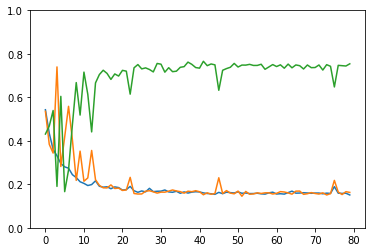

In [20]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.plot(loss_train)
plt.plot(loss_valid)
plt.plot(acc_valid)
plt.ylim(0,1)

In [21]:
net.export('Segnet2-2')
net.save_params('Segnet2-2')
#net.load_params('segnet.params', mx.gpu(0))


In [22]:
def predict(im):
    data = normalize_image(im)
    data = data.transpose((2,0,1)).expand_dims(axis=0)
    pred = net(data.as_in_context(ctx[0]))
    #print (pred.shape)
    
    return pred.reshape((pred.shape[2], pred.shape[3]))

(512, 512)
(512, 640)
(520, 696)
(512, 512)
(512, 576)
(520, 696)


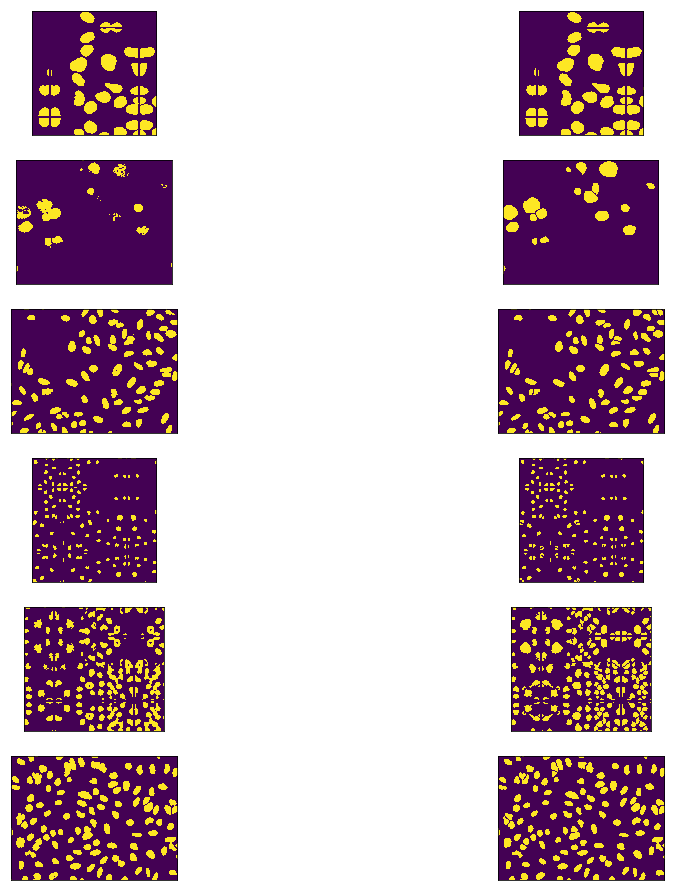

In [23]:
test_images, test_labels, test_weights = read_images(VAL_PATH,val_ids)

n = 6
imgs = []
for i in range(n):
    x = test_images[i]
    pred = predict(x)
    print (pred.shape)
    imgs += [ pred>0.5 , test_labels[i][:,:,0]  ] # , test_weights[i][:,:,0]  ]

utils.show_images(imgs, nrows=n, ncols=2, figsize=(16,16))
#[im.shape for im in imgs]